# Piece-wise model on FDIC SDI Dataset

#### This report analyzes FDIC SDI data from 2007 - 2019, focusing on Net Asset variable. Statistical analysis is used to build piece-wise models of regression prediction.

##### ----- Fortuna Zhang, June 2020

## MS Azure Set up

In [1]:
import logging

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pandas.plotting import autocorrelation_plot
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import signal
from statsmodels.tsa.seasonal import seasonal_decompose

from azureml.core.workspace import Workspace
from azureml.core.experiment import Experiment
import azureml.dataprep as dprep
from azureml.automl.core.featurization import FeaturizationConfig
from azureml.train.automl import AutoMLConfig
from azureml.core.dataset import Dataset

import warnings
warnings.filterwarnings('ignore')

In [2]:
#check the version of azureml.core
print("the version of azureml is ", azureml.core.VERSION)

the version of azureml is  1.6.0


## Obtain workspace information

In [3]:
ws = Workspace.from_config()

#your experiment_name
experiment_name = 'test'
experiment = Experiment(ws,experiment_name)

output = {}
output['Subscription ID'] = ws.subscription_id
output['Workspace Name'] = ws.name
output['Resource Group'] = ws.resource_group
output['Location'] = ws.location
output['Experiment Name'] = experiment.name
pd.set_option('display.max_colwidth', -1)
outputDf = pd.DataFrame(data = output, index = [''])
outputDf.T

,
Subscription ID,de1faa6a-bb72-4633-8d66-b148cb10deb9
Workspace Name,Fortuna
Resource Group,Main
Location,westcentralus
Experiment Name,test


## Create an AmlCompute as compute target

In [4]:
from azureml.core.compute import ComputeTarget, AmlCompute
from azureml.core.compute_target import ComputeTargetException

#name of the cluster 
cluster_name = 'FortunaCom'

try:
    compute_target = ComputeTarget(workspace=ws,name=cluster_name)
    print("Found Compute, use it!")
except ComputeTargetException:
    compute_config = AmlCompute.provisioning_configuration(vm_size='STANDARD_D2_V2',max_nodes=4)
    compute_target =  ComputeTarget.create(ws,cluster_name,compute_config)

compute_target.wait_for_completion(show_output=True)

Found Compute, use it!

Running


## Load Data

In [10]:
import pandas as pd

from azureml.core import Workspace, Dataset

subscription_id = 'de1faa6a-bb72-4633-8d66-b148cb10deb9' # compute id
resource_group = 'Main'
workspace_name = 'Fortuna'

workspace = Workspace(subscription_id, resource_group, workspace_name)

dataset = Dataset.get_by_name(workspace, name='SDI_test')
df = dataset.to_pandas_dataframe()

### Trend Scanning Labelling for regression

In [11]:
import statsmodels.api as sm1

def tValLinR(close):
# tValue from a linear trend
    x=np.ones((close.shape[0],2))
    x[:,1]=np.arange(close.shape[0])
    ols=sm1.OLS(close,x).fit()
    return ols.tvalues[1]

In [12]:
tValLinR(deseasonalizedNet)

NameError: name 'deseasonalizedNet' is not defined

In [ ]:
def getBinsFromTrend(molecule,close,span):
# ’’’
# Derive labels from the sign of t-value of linear trend
# Output includes:
# - t1: End time for the identified trend
# - tVal: t-value associated with the estimated trend coefficient
# - bin: Sign of the trend
# ’’’
    out=pd.DataFrame(index=molecule,columns=['t1','tVal','bin'])
    hrzns=range(*span)
    for dt0 in molecule:
        df0=pd.Series()
        iloc0=close.index.get_loc(dt0)
        if iloc0+max(hrzns)>close.shape[0]:continue
        for hrzn in hrzns:
            dt1=close.index[iloc0+hrzn-1]
            df1=close.loc[dt0:dt1]
            df0.loc[dt1]=tValLinR(df1.values)
        dt1=df0.replace([-np.inf,np.inf,np.nan],0).abs().idxmax()
        out.loc[dt0,['t1','tVal','bin']]=df0.index[-1],df0[dt1],np.sign(df0[dt1]) # prevent leakage
    out['t1']=pd.to_datetime(out['t1'])
    out['bin']=pd.to_numeric(out['bin'],downcast='signed')
    return out.dropna(subset=['bin'])

In [ ]:
# df0=pd.Series(np.random.normal(0,.1,100)).cumsum()
# df0+=np.sin(np.linspace(0,10,df0.shape[0]))
import matplotlib.pyplot as plt

df1=getBinsFromTrend(deseasonalizedNet.index,deseasonalizedNet,[3,5,1])
plt.scatter(df1.index,deseasonalizedNet.loc[df1.index].values,c=df1['bin'].values, cmap='viridis')
# plt.savefig('fig 5.1.png');mpl.clf();mpl.close()
# plt.scatter(df1.index,deseasonalizedNet.loc[df1.index].values,c=df1['tVal'].values,cmap='viridis')


Highly positive t-values are plotted in yellow, and highly negative t-values are plotted in violet. Positive values close to zero are plotted in green, and negative values close to zero are plotted in blue.

In [ ]:
# Deseasonalize Net Asset, Not detrending
result_mul = seasonal_decompose(dategroup.netasset, model='multiplicative', freq=4)

deseasonalizedNetonly = dategroup.netasset / result_mul.seasonal
# deseasonalizedNetonly
df2=getBinsFromTrend(deseasonalizedNetonly.index,deseasonalizedNet,[3,5,1])
plt.scatter(df2.index,deseasonalizedNetonly.loc[df2.index].values,c=df2['bin'].values, cmap='viridis')

In [ ]:
# Compare stationary and non-stationary netasset
df1=getBinsFromTrend(deseasonalizedNet.index,deseasonalizedNet,[3,5,1])
df2=getBinsFromTrend(deseasonalizedNetonly.index,deseasonalizedNet,[3,5,1])
df3=getBinsFromTrend(dategroup.index,dategroup.netasset,[3,5,1])
dfmerge = df1.merge(df2,on='time').merge(df3,on='time')
dfmerge

Trend scanning labels of netasset are the same for detrending&deseasonlizing and only deseasonalizing, but different from the original trends. This suggests that  detrending&deseasonlizing matters in trend labelling.

In [ ]:
# df1.to_csv('trendlabel.csv')

In [ ]:
df1.loc['2017-09-30']

In [ ]:
# # pip install mlfinlab
# import numpy as np
# import pandas as pd
# # from mlfinlab.labeling import trend_scanning_labels

# # In 2008, EEM had some clear trends
# dfn = df['netasset'].loc[df.year(2007):df.year(2019)]
# t_events = dfn.index # Get indexes that we want to label
df[df.specgrp==3]

### Bank Clustering

Clustering is to seperate bank and build regression models respectively. Clustering methods can be K-means, specialization group, public/non-public, etc.

#### Specialization group (all banks)

In [13]:
specgroup = df.groupby('specgrp')

# specgroup[['asset','liab','netasset']].describe()
# specgroup[['asset','liab','netasset']].median()
specgroup.agg({'asset': ['min', 'max', 'median', 'skew'],'liab': ['min', 'max', 'median', 'skew'],\
              'netasset':['min', 'max', 'median', 'skew','count']})

asset                                   liab                       \
             min       max     median      skew     min       max     median   
specgrp                                                                        
2           2239   3986026    81571.0  6.066628    1588   3573263    72214.5   
3          11094     11350    11104.0  1.722788     520       523      522.0   
4           2911  20601349   216980.0  7.099980     666  17961968   194433.0   
5           2823  17650215   140777.0  9.399644     553  16358975   124091.0   
6           6813   7176775   108020.0  7.116638    5847   6568453    95160.0   
7           2992    997187    83217.5  2.791651      14    916057    71607.0   
8           3063    998891    98388.0  2.189886     395    927567    87161.5   
9        1000668  13572632  1551141.0  2.291075  771128  12551884  1385889.0   

                  netasset                                       
             skew      min      max    median      skew   count  
specgrp                                                          
2        6.113488    -3178   412763    9042.0  5.573065   71058  
3       -0.935220    10572    10827   10584.0  1.718507       3  
4        7.007138  -161976  2990651   22367.0  8.639206  122268  
5        9.562398    -8467  1398724   16344.0  9.246331   23707  
6        7.157078     -666   990733   11900.0  9.116038    2583  
7        2.706969     -501   684905   11095.5  9.973207   12346  
8        2.203662   -13660   247648   10916.0  3.000141   29000  
9        2.319193    25171  2037472  176453.0  2.421863     723

An indicator of an institution’s primary specialization in terms of asset concentration. note: (groups are hierarchical and mutually exclusive): <br>
1 international Specialization – Institutions with assets greater than 10 billion and more than 25 percent of total assets in foreign offices. <br>
2 Agricultural Specialization – Banks with agricultural production loans plus real estate loans secured by farmland in excess of 25 percent of total loans and leases. <br>
3 Credit-card Specialization – Institutions with credit-card loans plus securitized receivables in excess of 50 percent of total assets plus securitized receivables. <br>
4 Commercial Lending Specialization – Institutions with commercial and industrial loans, plus real estate construction and development loans, plus loans secured by commercial real estate properties in excess of 25 percent of total assets. <br>
5 Mortgage Lending Specialization – Institutions with residential mortgage loans, plus mortgage-backed securities, in excess of 50 percent of total assets. <br>
6 Consumer Lending Specialization – Institutions with residential mortgage loans, plus credit-card loans, plus other loans to individuals, in excess of 50 percent of total assets. <br>
7 Other Specialized $1 Billion – Institutions with assets greater than 1 billion that do not meet any of the definitions above, they have significant lending activity with no identified asset concentrations. 

In [14]:
from scipy import stats
specgrp2 = df[df['specgrp']==2].netasset
specgrp3 = df[df['specgrp']==3].netasset
specgrp4 = df[df['specgrp']==4].netasset
specgrp5 = df[df['specgrp']==5].netasset
specgrp6 = df[df['specgrp']==6].netasset
specgrp7 = df[df['specgrp']==7].netasset
specgrp8 = df[df['specgrp']==8].netasset
specgrp9 = df[df['specgrp']==9].netasset

specgrp = [specgrp2,specgrp3,specgrp4,specgrp5,specgrp6,specgrp7,specgrp8,specgrp9]
table={}
# row = [2,3,4,5,6,7,8,9]
# column=[2,3,4,5,6,7,8,9]
# result=[]

for i in range(len(specgrp)):
    for n in range(len(specgrp)): 
        table[(i,n)]=stats.ttest_ind(specgrp[i], specgrp[n], equal_var=False).pvalue
        
# result
# min_list = sorted(result)[:20]
# table= pd.DataFrame(table, index = row, columns = column)
# table = pd.DataFrame.from_dict(table,orient='index')
table 
sorted(table.items(), key=lambda x: x[1])

[((0, 2), 0.0),
 ((0, 3), 0.0),
 ((1, 3), 0.0),
 ((2, 0), 0.0),
 ((2, 5), 0.0),
 ((2, 6), 0.0),
 ((3, 0), 0.0),
 ((3, 1), 0.0),
 ((5, 2), 0.0),
 ((6, 2), 0.0),
 ((3, 6), 1.4442664866187306e-298),
 ((6, 3), 1.4442664866187306e-298),
 ((3, 5), 7.562460701074621e-271),
 ((5, 3), 7.562460701074621e-271),
 ((1, 2), 2.8654908210512755e-204),
 ((2, 1), 2.8654908210512755e-204),
 ((1, 7), 6.482673542293372e-126),
 ((7, 1), 6.482673542293372e-126),
 ((0, 7), 3.764299446099537e-123),
 ((7, 0), 3.764299446099537e-123),
 ((5, 7), 2.477871772495684e-121),
 ((7, 5), 2.477871772495684e-121),
 ((6, 7), 3.434530662221925e-121),
 ((7, 6), 3.434530662221925e-121),
 ((4, 7), 4.643252290335517e-112),
 ((7, 4), 4.643252290335517e-112),
 ((3, 7), 2.7639403707115526e-108),
 ((7, 3), 2.7639403707115526e-108),
 ((0, 6), 2.1627190524212193e-102),
 ((6, 0), 2.1627190524212193e-102),
 ((2, 7), 1.2050281270101744e-101),
 ((7, 2), 1.2050281270101744e-101),
 ((2, 3), 1.516065171418837e-70),
 ((3, 2), 1.51606517141883

<font color='red'>For all banks: Clustering based on specialization group is group1:(2,3), group2:(4,5),group3:(6,7,8),group4:(9), according to the significant difference of net asset. </font>

In [15]:
def corrcoef(dframe):

    fmatrix = dframe.values
    rows, cols = fmatrix.shape

    r = np.ones((cols, cols), dtype=float)
    p = np.ones((cols, cols), dtype=float)

    for i in range(cols):
        for j in range(cols):
            if i == j:
                r_, p_ = 1., 1.
            else:
                r_, p_ = stats.ttest_ind(fmatrix[i].dropna().values, fmatrix[j].dropna().values, equal_var=False).pvalue

            r[j][i] = r_
            p[j][i] = p_

    return r, p


In [16]:
list_columns = [] 
for x in link_href_list: 
    urllib.request.urlopen(x)
    html = urlopen(x)
    bs = BeautifulSoup(html, "lxml")    
    table=bs.find('tbody')
    rows = table.tr.next_siblings
    list_rows = []

    for row in rows:
        a=row.find('td').get_text().strip()
        list_rows.append(a)
    list_columns.append(list_rows)
list_columns.DataFrame()

NameError: name 'link_href_list' is not defined

In [17]:
stats.ttest_ind(i.dropna().values, n.dropna().values, equal_var=False).pvalue

AttributeError: 'int' object has no attribute 'dropna'

#### Public and Non-public bank

In [1]:
dataset2 = Dataset.get_by_name(workspace, name='publicbank')
df2 = dataset2.to_pandas_dataframe()
dataset3 = Dataset.get_by_name(workspace, name='nonpublicbank')
df3 = dataset3.to_pandas_dataframe()
dataset4 = Dataset.get_by_name(workspace, name='SDI_cleaned')
df4 = dataset4.to_pandas_dataframe()

NameError: name 'Dataset' is not defined

In [ ]:
# Public
public = df2.MKTCAP
public.describe()

In [ ]:
# Nonpublic
df3['netasset']=df3['asset']-df3['liab']
nonpublic = df3['netasset']
nonpublic.describe()

In [ ]:
# All
df4['netasset']=df4['asset']-df4['liab']
allbank = df4['netasset']
allbank.describe()

In [ ]:
fig, ax = plt.subplots(figsize=(15,9))
allbank.plot(color='red',label='All banks')
public.plot(color='blue',label='Public banks')
nonpublic.plot(color='green',label='Non Public banks')
plt.legend(loc="upper left")
plt.title('Public bank vs Non-public bank Net Assets')

In [ ]:
fig, ax = plt.subplots(figsize=(15,9))
allbank.describe().plot(color='red',label='All banks')
public.describe().plot(color='blue',label='Public banks')
nonpublic.describe().plot(color='green',label='Non Public banks')
plt.legend(loc="upper left")
plt.title('Public bank vs Non-public bank Net Assets')

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(1,2,figsize=(15,9))
public.hist(ax=ax[0])
nonpublic.hist(ax=ax[1],color='orange',title = 'Nonpublic bank')

In [ ]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=public, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Public bank distribution')

In [ ]:
import matplotlib.pyplot as plt

# An "interface" to matplotlib.axes.Axes.hist() method
n, bins, patches = plt.hist(x=nonpublic, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=1)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('Non Public bank distribution')

In [ ]:
n, bins, patches = plt.hist(x=allbank, bins='auto', color='#0504aa',
                            alpha=0.7, rwidth=20)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.title('All bank distribution')

Kernel Density Estimate (KDE)is a way to estimate the probability density function (PDF) of the random variable that “underlies” our sample. KDE is a means of data smoothing.

In [ ]:
# from pandas.plotting import scatter_matrix
# scatter_matrix(allbank, alpha=0.2, figsize=(6, 6), diagonal='kde')

In [ ]:
fig, ax = plt.subplots()
public.plot.kde(ax=ax, legend=False, title='Public bank KDE')
public.plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')

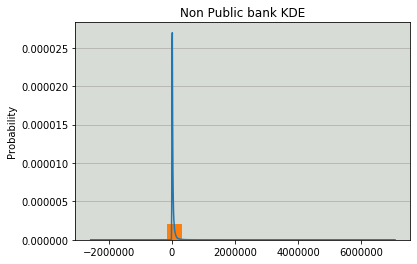

In [19]:
fig, ax = plt.subplots()
nonpublic.plot.kde(ax=ax, legend=False, title='Non Public bank KDE')
nonpublic.plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')

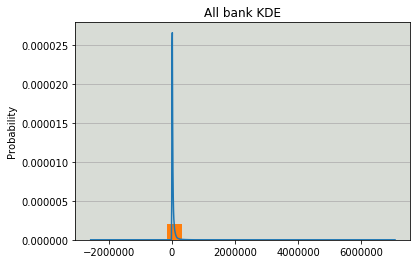

In [20]:
fig, ax = plt.subplots()
allbank.plot.kde(ax=ax, legend=False, title='All bank KDE')
allbank.plot.hist(density=True, ax=ax)
ax.set_ylabel('Probability')
ax.grid(axis='y')
ax.set_facecolor('#d8dcd6')

#### T-student test for public & nonpublic banks

In [21]:
from scipy import stats
print(stats.ttest_ind(public.dropna().values, nonpublic.dropna().values, equal_var=False))
print(stats.ttest_ind(public.dropna().values, allbank.dropna().values, equal_var=False))
print(stats.ttest_ind(nonpublic.dropna().values, allbank.dropna().values, equal_var=False))

Ttest_indResult(statistic=18.29634759175089, pvalue=4.112417214517605e-70)
Ttest_indResult(statistic=18.27161411314973, pvalue=6.123609137604887e-70)
Ttest_indResult(statistic=-6.412731449908313, pvalue=1.4303197930150675e-10)


In [22]:
nonpubgroup = df3.groupby('specgrp')
df3.specgrp.value_counts()

4    168123
2    76788 
8    35201 
5    28565 
7    14394 
6    3005  
9    780   
3    3     
Name: specgrp, dtype: int64

In [23]:
df3.head()

,Column1,cert,docket,fed_rssd,rssdhcr,name,city,stalp,zip,repdte,...,EXCHCD,TICKER,COMNAM,PRC,SHROUT,exchange,industry,scalemarketcap,MKTCAP,netasset
0,0,9,9781,563907,1115424.0,Union Trust Company,Ellsworth,ME,4605,2007-06-30,...,None,None,None,None,None,None,None,None,None,38623
1,1,9,9781,563907,1115424.0,Union Trust Company,Ellsworth,ME,4605,2007-09-30,...,None,None,None,None,None,None,None,None,None,40280
2,2,9,9781,563907,1115424.0,Union Trust Company,Ellsworth,ME,4605,2007-12-31,...,None,None,None,None,None,None,None,None,None,31112
3,3,35,9177,749635,1129533.0,AuburnBank,Auburn,AL,36830,2007-03-31,...,None,None,None,None,None,None,None,None,None,51924
4,4,35,9177,749635,1129533.0,AuburnBank,Auburn,AL,36830,2007-06-30,...,None,None,None,None,None,None,None,None,None,49344


In [24]:
nonpubgroup.agg({'asset': ['min', 'max', 'median', 'skew'],'liab': ['min', 'max', 'median', 'skew'],\
              'netasset':['min', 'max', 'median', 'skew','count']})

asset                                    liab                     \
             min       max     median       skew     min       max   median   
specgrp                                                                       
2        2239     3986026   85192.5    5.726354   1588    3573263   75555     
3        11094    11350     11104.0    1.722788   520     523       522       
4        2911     48894931  225472.0   18.464876  666     44233208  202192    
5        2823     17650215  145793.0   8.708934   553     16358975  129123    
6        6813     7176775   107625.0   9.091636   5847    6568453   94378     
7        2500     997187    91663.0    2.587082   0       916057    80050     
8        3063     998891    106687.0   2.137303   395     927567    94525     
9        1000668  13572632  1395277.5  4.030560   771128  12551884  1253602   

                   netasset                                        
              skew      min      max    median       skew   count  
specgrp                                                            
2        5.752703  -3178     412763   9426.5    5.507756   76788   
3       -0.935220   10572    10827    10584.0   1.718507   3       
4        18.966384 -161976   4661723  23093.0   14.182358  168123  
5        9.003753  -8467     1398724  16647.0   7.293670   28565   
6        9.314665  -666      608322   11885.0   6.916872   3005    
7        2.553599  -501      684905   12198.0   8.605052   14394   
8        2.149652  -13660    247648   11782.0   2.822620   35201   
9        4.079516   25171    1368637  149716.0  3.518515   780

An indicator of an institution�s primary specialization in terms of asset concentration.

Note: (Groups are hierarchical and mutually exclusive):

1 - International Specialization � Institutions with assets greater than $10 billion and more than 25 percent of total assets in foreign offices.

2 - Agricultural Specialization � Banks with agricultural production loans plus real estate loans secured by farmland in excess of 25 percent of total loans and leases.

3 - Credit-card Specialization � Institutions with credit-card loans plus securitized receivables in excess of 50 percent of total assets plus securitized receivables.

4 - Commercial Lending Specialization � Institutions with commercial and industrial loans, plus real estate construction and development loans, plus loans secured by commercial real estate properties in excess of 25 percent of total assets.

5 - Mortgage Lending Specialization � Institutions with residential mortgage loans, plus mortgage-backed securities, in excess of 50 percent of total assets.

6 - Consumer Lending Specialization � Institutions with residential mortgage loans, plus credit-card loans, plus other loans to individuals, in excess of 50 percent of total assets.

7 - Other Specialized < $1 Billion � Institutions with assets less than $1 billion and with loans and leases are less than 40 percent of total assets.

8 - All Other < $1 Billion � Institutions with assets less than $1 billion that do not meet any of the definitions above, they have significant lending activity with no identified asset concentrations.

9 - All Other > $1 Billion � Institutions with assets greater than $1 billion that do not meet any of the definitions above, they have significant lending activity with no identified asset concentrations.

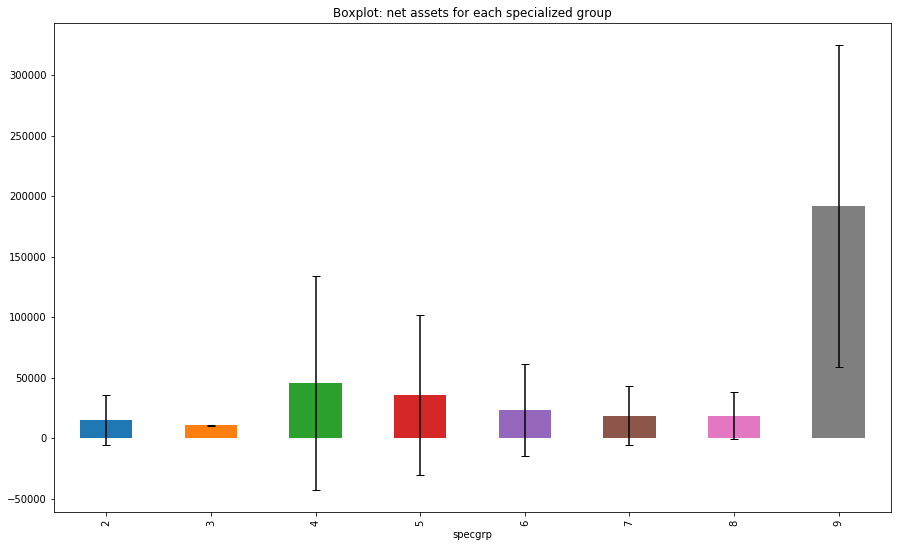

In [37]:
# Group by index labels and take the means and standard deviations for each group
means = nonpubgroup.netasset.mean()
errors = nonpubgroup.netasset.std()

fig, ax = plt.subplots(figsize=(15,9))
means.plot.bar(yerr=errors, ax=ax, capsize=4, title = 'Boxplot: net assets for each specialized group')
# nonpubgroup.netaseet.plot(table==np.round(nonpubgroup.T, 2),ax=ax)

#### student-t test for specialized groups

In [27]:
from scipy import stats
specgrp2 = df3[df3['specgrp']==2].netasset
specgrp3 = df3[df3['specgrp']==3].netasset
specgrp4 = df3[df3['specgrp']==4].netasset
specgrp5 = df3[df3['specgrp']==5].netasset
specgrp6 = df3[df3['specgrp']==6].netasset
specgrp7 = df3[df3['specgrp']==7].netasset
specgrp8 = df3[df3['specgrp']==8].netasset
specgrp9 = df3[df3['specgrp']==9].netasset

specgrp = [specgrp2,specgrp3,specgrp4,specgrp5,specgrp6,specgrp7,specgrp8,specgrp9]
table={}

for i in range(len(specgrp)):
    for n in range(len(specgrp)): 
        table[(i,n)]=stats.ttest_ind(specgrp[i], specgrp[n], equal_var=False).pvalue
        

table = pd.DataFrame.from_dict(table,orient='index',columns=['p value'])
table['reject null']= np.where(table['p value']<0.01, 'true', 'false')
# table['reject null']= np.where(table['p value']<0.05, 'true', 'false')
table['reject null'].value_counts()
table.loc[table['reject null']=='false']
# sorted(table.items(), key=lambda x: x[1])

,p value,reject null
"(0, 0)",1.000000,false
"(1, 1)",1.000000,false
"(2, 2)",1.000000,false
"(3, 3)",1.000000,false
"(4, 4)",1.000000,false
"(5, 5)",1.000000,false
"(5, 6)",0.140683,false
"(6, 5)",0.140683,false
"(6, 6)",1.000000,false
"(7, 7)",1.000000,false


<font color='blue'>From t test, only specialized group 5 and 6 are not significant different. So group 5 and 6 should be clustered together.</font>

#### one-way ANOVA test
ANOVA Hypotheses

Null hypotheses: Groups means are equal (no variation in means of groups)
Alternative hypotheses: At least, one group mean is different from other groups

ANOVA Assumptions

Residuals (experimental error) are normally distributed (Shapiro Wilks Test)
Homogeneity of variances (variances are equal between treatment groups) (Levene or Bartlett Test)
Observations are sampled independently from each other

In [28]:
nongroupzip = list(zip(specgrp2,specgrp3,specgrp4,specgrp5,specgrp6,specgrp7,specgrp8,specgrp9))
nongroupdf = pd.DataFrame(nongroupzip, columns=['2','3','4','5','6','7','8','9'])

In [29]:
# load packages
import scipy.stats as stats
# stats f_oneway functions takes the groups as input and returns F and P-value
fvalue, pvalue = stats.f_oneway(nongroupdf['2'], nongroupdf['3'], nongroupdf['4'], nongroupdf['5'],nongroupdf['6'],\
                                nongroupdf['7'],nongroupdf['8'],nongroupdf['9'])
print(fvalue, pvalue)
# 17.492810457516338 2.639241146210922e-05

# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols
# reshape the d dataframe suitable for statsmodels package 
d_melt = pd.melt(nongroupdf.reset_index(), id_vars=['index'], value_vars=['2','3','4','5','6','7','8','9'])
# replace column names
d_melt.columns = ['index', 'treatments', 'value']
# Ordinary Least Squares (OLS) model
model = ols('value ~ C(treatments)', data=d_melt).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

332.747717247821 4.104834438403661e-16


,sum_sq,df,F,PR(>F)
C(treatments),1.430824e+10,7.0,332.747717,4.104834e-16
Residual,9.828629e+07,16.0,NaN,NaN


The P-value obtained from ANOVA analysis is significant (P<0.05), and therefore, we conclude that there are significant differences among treatments.

#### Tukey HSD test 
To know the pairs of significant different treatments, we will perform multiple pairwise comparison (Post-hoc comparison) analysis using Tukey HSD test.

In [30]:
# load packages
from statsmodels.stats.multicomp import pairwise_tukeyhsd
# perform multiple pairwise comparison (Tukey HSD)
m_comp = pairwise_tukeyhsd(endog=d_melt['value'], groups=d_melt['treatments'], alpha=0.05)
print(m_comp)

      Multiple Comparison of Means - Tukey HSD, FWER=0.05      
group1 group2   meandiff  p-adj     lower       upper    reject
---------------------------------------------------------------
     2      3      2919.0 0.8047  -4087.7264   9925.7264  False
     2      4  43809.6667  0.001  36802.9403   50816.393   True
     2      5  28929.6667  0.001  21922.9403   35936.393   True
     2      6   1624.6667    0.9  -5382.0597    8631.393  False
     2      7  22065.6667  0.001  15058.9403   29072.393   True
     2      8  17683.3333  0.001   10676.607  24690.0597   True
     2      9  76805.3333  0.001   69798.607  83812.0597   True
     3      4  40890.6667  0.001  33883.9403   47897.393   True
     3      5  26010.6667  0.001  19003.9403   33017.393   True
     3      6  -1294.3333    0.9  -8301.0597    5712.393  False
     3      7  19146.6667  0.001  12139.9403   26153.393   True
     3      8  14764.3333  0.001    7757.607  21771.0597   True
     3      9  73886.3333  0.001   66879

<font color='red'>From ANOVA test, specialized group 2&3&6, group 7&8, group 5&7 are not significant different, though the p value for 5&7 is acceptably low and if back check the assets/liabilities/netassets values are not similar. Therefore the final clusters are: cluster1: (2,3,6),(7,8),(4),(5),(9).</font>
An indicator of an institution�s primary specialization in terms of asset concentration.

Note: (Groups are hierarchical and mutually exclusive):

1 - International Specialization � Institutions with assets greater than $10 billion and more than 25 percent of total assets in foreign offices.

2 - Agricultural Specialization � Banks with agricultural production loans plus real estate loans secured by farmland in excess of 25 percent of total loans and leases.

3 - Credit-card Specialization � Institutions with credit-card loans plus securitized receivables in excess of 50 percent of total assets plus securitized receivables.

4 - Commercial Lending Specialization � Institutions with commercial and industrial loans, plus real estate construction and development loans, plus loans secured by commercial real estate properties in excess of 25 percent of total assets.

5 - Mortgage Lending Specialization � Institutions with residential mortgage loans, plus mortgage-backed securities, in excess of 50 percent of total assets.

6 - Consumer Lending Specialization � Institutions with residential mortgage loans, plus credit-card loans, plus other loans to individuals, in excess of 50 percent of total assets.

7 - Other Specialized < $1 Billion � Institutions with assets less than $1 billion and with loans and leases are less than 40 percent of total assets.

8 - All Other < $1 Billion � Institutions with assets less than $1 billion that do not meet any of the definitions above, they have significant lending activity with no identified asset concentrations.

9 - All Other > $1 Billion � Institutions with assets greater than $1 billion that do not meet any of the definitions above, they have significant lending activity with no identified asset concentrations.

Test ANOVA assumptions <br>
Shapiro-Wilk test: can be used to check the normal distribution of residuals . Null hypothesis: data is drawn from normal distribution. <br>
Bartlett’s test: As the data is drawn from normal distribution, use Bartlett’s test to check the Homogeneity of variances. Null hypothesis: samples from populations have equal variances.<br>
Levene test can be used to check the Homogeneity of variances when the data is not drawn from normal distribution.

In [31]:
# load packages
import scipy.stats as stats
w, pvalue = stats.shapiro(model.resid)
print(w, pvalue)

0.8495645523071289 0.002145778387784958


In [32]:
w, pvalue = stats.levene(nongroupdf['2'], nongroupdf['3'], nongroupdf['4'], nongroupdf['5'],nongroupdf['6'],\
                                nongroupdf['7'],nongroupdf['8'],nongroupdf['9'])
print(w, pvalue)

1.3954746245557403 0.2733428367785623


In [33]:
w, pvalue = stats.bartlett(nongroupdf['2'], nongroupdf['3'], nongroupdf['4'], nongroupdf['5'],nongroupdf['6'],\
                                nongroupdf['7'],nongroupdf['8'],nongroupdf['9'])
print(w, pvalue)

35.813786570246236 7.859956223721087e-06


Since Shapiro-Wilk test shows we should reject null that data is normal distribution, we should then use Levene test to test the homogeneity of variances. From Levene test it shows that we could not reject null that samples have equal variances, therefore the data meets the ANOVA assumptions.

#### Outlier

In [ ]:
#Clean the data by removing orders with 0 items or having more items than 99.5th percentile orders
print(df3.netasset.quantile(.995))
print(nonpubgroup.netasset.quantile(.995))
nonpubgroup_clean = nonpubgroup.netasset.apply(lambda x : x>0) & nonpubgroup.netasset.apply(lambda x : x<x.quantile(.995))
nonpubgroup_clean.count()

In [ ]:
# outlier = nonpubgroup['netasset'].transform(lambda x : x>1000000)
# outlier

In [ ]:
# nonpubgroup = df3.groupby('specgrp')
# # Plot
# fig, ax = plt.subplots()
# ax.margins(0.05) # Optional, just adds 5% padding to the autoscaling
# for name, group in nonpubgroup:
#     ax.plot(group.repdte, group.netasset, marker='o', linestyle='', ms=12, label=name)
# ax.legend()
# plt.show()

In [ ]:
def abplot(N_A, N_B, bcr, d_hat, sig_level=0.05, show_power=False,
           show_alpha=False, show_beta=False, show_p_value=False,
           show_legend=True):
    """Example plot of AB test
    Example:
        abplot(n=4000, bcr=0.11, d_hat=0.03)
    Parameters:
        n (int): total sample size for both control and test groups (N_A + N_B)
        bcr (float): base conversion rate; conversion rate of control
        d_hat: difference in conversion rate between the control and test
            groups, sometimes referred to as **minimal detectable effect** when
            calculating minimum sample size or **lift** when discussing
            positive improvement desired from launching a change.
    Returns:
        None: the function plots an AB test as two distributions for
        visualization purposes
    """
    # create a plot object
    fig, ax = plt.subplots(figsize=(12, 6))

    # define parameters to find pooled standard error
    X_A = bcr * N_A
    X_B = (bcr + d_hat) * N_B
    stderr = pooled_SE(N_A, N_B, X_A, X_B)

    # plot the distribution of the null and alternative hypothesis
    plot_null(ax, stderr)
    plot_alt(ax, stderr, d_hat)

    # set extent of plot area
    ax.set_xlim(-8 * stderr, 8 * stderr)

    # shade areas according to user input
    if show_power:
        show_area(ax, d_hat, stderr, sig_level, area_type='power')
    if show_alpha:
        show_area(ax, d_hat, stderr, sig_level, area_type='alpha')
    if show_beta:
        show_area(ax, d_hat, stderr, sig_level, area_type='beta')

    # show p_value based on the binomial distributions for the two groups
    if show_p_value:
        null = ab_dist(stderr, 'control')
        p_value = p_val(N_A, N_B, bcr, bcr+d_hat)
        ax.text(3 * stderr, null.pdf(0),
                'p-value = {0:.3f}'.format(p_value),
                fontsize=12, ha='left')

    # option to show legend
    if show_legend:
        plt.legend()

    plt.xlabel('d')
    plt.ylabel('PDF')
    plt.show()

In [ ]:
# n = public.count()+allbank[:2998].count()
# bcr = allbank[:2998]
# d_hat = public - allbank[:2998]
# abplot(n, bcr, d_hat)